In [1]:
import os, sys
sys.path.append("..")

In [2]:
from tensorized_algorithm import pauli_utils
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from functools import reduce

from qiskit.quantum_info import SparsePauliOp

# Error by applying orders

In the document, we test the Trotter error by applying ordering of each local Hamiltonian.

**Question**

How much error rate is generated, if we apply the commuting partition order, in Trotterization circuit?.

Common error rate of p-th order Trotterization is $O(t^{p+1})$. In "Theory of Trotter Error" paper, they derived a $\alpha$ constant for $O(\alpha t^{p+1})$.


**Observation**

In simple system, $n<3$, the commuting pair errors were 2-10 times larger than random sequence.
However, in larger and complicated systems, $n>4$, the commuting order averagely show good error rates.
The efficiency is getting better as $t$ increases in $\exp(-it H)$.

In [3]:
def mat_diff(A, B):
    U = np.matrix(A - B)
    return 0.5*pauli_utils.fro_inner(U, U)
def matmul(a,b):
    return a@b
def get_U_l(hs, n, t):
    tn = t/n
    us = [expm(-1j*tn*h) for h in hs]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U

In [10]:
N = 4
A = np.random.rand(int(2**N), int(2**N))
T = A.T@A
H = np.matrix((T + 1j*T))
norm_H = 0.5*pauli_utils.fro_inner(H, H)
H *= 1/np.sqrt(norm_H) 


In [11]:
pa = SparsePauliOp.from_operator(H)

In [12]:
pa

SparsePauliOp(['IIII', 'IIIX', 'IIIZ', 'IIXI', 'IIXX', 'IIXZ', 'IIYY', 'IIZI', 'IIZX', 'IIZZ', 'IXII', 'IXIX', 'IXIZ', 'IXXI', 'IXXX', 'IXXZ', 'IXYY', 'IXZI', 'IXZX', 'IXZZ', 'IYIY', 'IYXY', 'IYYI', 'IYYX', 'IYYZ', 'IYZY', 'IZII', 'IZIX', 'IZIZ', 'IZXI', 'IZXX', 'IZXZ', 'IZYY', 'IZZI', 'IZZX', 'IZZZ', 'XIII', 'XIIX', 'XIIZ', 'XIXI', 'XIXX', 'XIXZ', 'XIYY', 'XIZI', 'XIZX', 'XIZZ', 'XXII', 'XXIX', 'XXIZ', 'XXXI', 'XXXX', 'XXXZ', 'XXYY', 'XXZI', 'XXZX', 'XXZZ', 'XYIY', 'XYXY', 'XYYI', 'XYYX', 'XYYZ', 'XYZY', 'XZII', 'XZIX', 'XZIZ', 'XZXI', 'XZXX', 'XZXZ', 'XZYY', 'XZZI', 'XZZX', 'XZZZ', 'YIIY', 'YIXY', 'YIYI', 'YIYX', 'YIYZ', 'YIZY', 'YXIY', 'YXXY', 'YXYI', 'YXYX', 'YXYZ', 'YXZY', 'YYII', 'YYIX', 'YYIZ', 'YYXI', 'YYXX', 'YYXZ', 'YYYY', 'YYZI', 'YYZX', 'YYZZ', 'YZIY', 'YZXY', 'YZYI', 'YZYX', 'YZYZ', 'YZZY', 'ZIII', 'ZIIX', 'ZIIZ', 'ZIXI', 'ZIXX', 'ZIXZ', 'ZIYY', 'ZIZI', 'ZIZX', 'ZIZZ', 'ZXII', 'ZXIX', 'ZXIZ', 'ZXXI', 'ZXXX', 'ZXXZ', 'ZXYY', 'ZXZI', 'ZXZX', 'ZXZZ', 'ZYIY', 'ZYXY', 'ZYYI', '

In [38]:
Hs = pa.matrix_iter()
H_com_group = [h.to_matrix() for h in pa.group_commuting()]

In [39]:
len(Hs), len(H_com_group)

(136, 21)

In [40]:
pauli_utils.fro_inner(np.matrix(H), np.matrix(H))/2

(0.9999999999999997-5.579584291299718e-19j)

In [65]:
identit_index = [i for i in range(len(H_com_group))]
random_index = [i for i in range(len(Hs))]
shuffle(random_index)

In [42]:
def get_U_n(hs, n, t, rand_index): #get general order u
    tn = t/n    
    us = [np.matrix(expm(-1j*tn*hs[i])) for i in rand_index]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U


In [66]:
n = 300
t = 2.5
U = expm(-1j*t*H)
Ug = get_U_n(Hs, n, t, random_index)
Uc = get_U_n(H_com_group, n, t, identit_index)

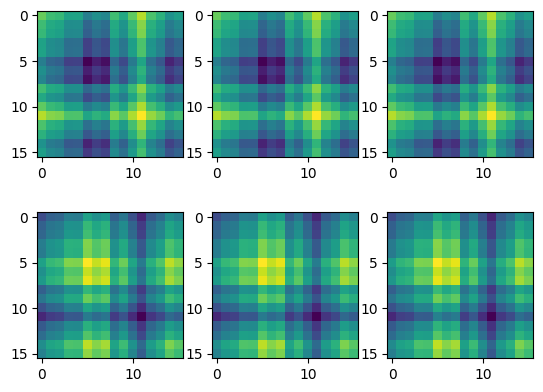

In [67]:
fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(U.real)
axes[1, 0].imshow(U.imag)

axes[0, 1].imshow(Ug.real)
axes[1, 1].imshow(Ug.imag)

axes[0, 2].imshow(Uc.real)
axes[1, 2].imshow(Uc.imag)

In [70]:
mat_diff(U, Ug).real, mat_diff(U, Uc).real

(11.34183498514449, 105.51229794468895)

In [71]:
from copy import deepcopy

In [72]:
from opttrot.pauli_utils import pstr_commute

In [73]:
n = 5
errs = []
ts = np.linspace(0.1, 2, 100)
pplist = pa.to_list()
max_i = len(Hs)

for t in ts:
    U = expm(-1j*t*H)
    Uc = get_U_n(H_com_group, n, t, identit_index)
    err_com = mat_diff(U, Uc)
    err = []
    min_err = err_com 
    optimal_index = None
    iter = 3000
    for l in range(1000):
        random_index = [i for i in range(len(Hs))]
        shuffle(random_index)
        Ug = get_U_n(Hs, n, t, random_index)
        err_c =mat_diff(U, Ug).real
        err.append(err_c)
        if min_err > err_c :
            optimal_index = deepcopy(random_index)
            min_err = err_c
    
    if optimal_index is not None:
        commute = []
        for i, j in enumerate(optimal_index):
            if i +1 >= max_i:
                break
            p1 = pplist[j][0]
            p2 = pplist[optimal_index[i+1]][0]
            commute.append(pstr_commute(p1, p2))
        commute = np.array(commute)
        M = max_i-1
        commute_num = commute.sum()
        cn = commute_num/M
        acn = 1-cn
        print(f"Commute ratio: {cn:.2}/{acn:.2}")
    
    e_max = max(err)
    e_min = min(err)
    percentage = (100*(np.abs(err_com))/e_max).real
    errs.append(percentage)
    print(f"{n}, {t:.3}", f"{percentage:.2}%", )

Commute ratio: 0.57/0.43
5, 0.1 1.8e+02%
Commute ratio: 0.52/0.48
5, 0.119 2.3e+02%
Commute ratio: 0.55/0.45
5, 0.138 2.1e+02%
Commute ratio: 0.51/0.49
5, 0.158 1.7e+02%
Commute ratio: 0.5/0.5
5, 0.177 1.9e+02%
Commute ratio: 0.6/0.4
5, 0.196 2.2e+02%
Commute ratio: 0.61/0.39
5, 0.215 2e+02%
Commute ratio: 0.56/0.44
5, 0.234 1.7e+02%


KeyboardInterrupt: 

In [74]:
errs

[176.06975183838432,
 227.44395887429138,
 210.14664395412103,
 172.90915339496686,
 187.8864389076978,
 221.91978138394532,
 200.498318684511,
 168.98813299393765]

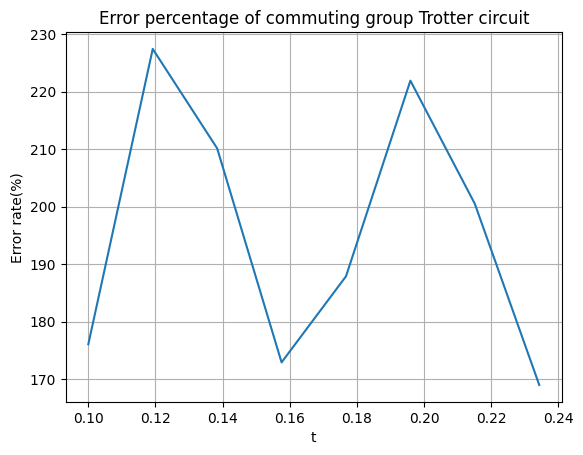

In [76]:
plt.plot(ts[:len(errs)], errs[-len(errs):])
plt.title("Error percentage of commuting group Trotter circuit")
plt.xlabel("t")
plt.ylabel("Error rate(%)")
plt.grid()

In [853]:
t = 0.9
U = expm(-1j*t*H)
Uc = get_U_n(H_com_group, n, t, identit_index)
err_com = mat_diff(U, Uc)
err = []
min_err = err_com 
optimal_index = None
iter = 50000
for l in range(1000):
    random_index = [i for i in range(len(Hs))]
    shuffle(random_index)
    Ug = get_U_n(Hs, n, t, random_index)
    err_c =mat_diff(U, Ug).real
    err.append(err_c)
    if min_err > err_c :
        optimal_index = deepcopy(random_index)
        min_err = err_c
    
e_max = max(err)
e_min = min(err)
percentage = (100*(err_com - e_min)/e_max).real

In [855]:
percentage

38.042211330556704

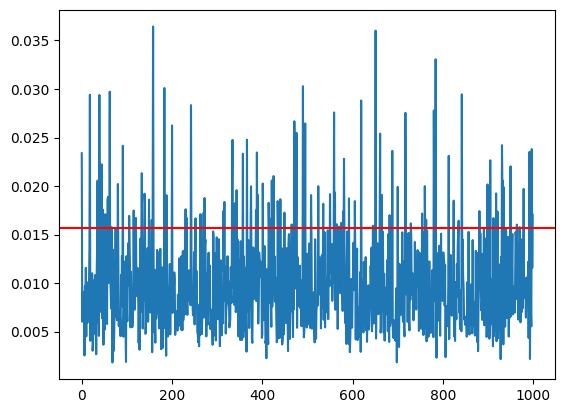

In [854]:
plt.plot(err)
plt.axhline(err_com, 0, iter, c="r")

In [856]:
optimal_index

[99,
 120,
 53,
 40,
 13,
 36,
 105,
 74,
 78,
 41,
 70,
 69,
 83,
 115,
 16,
 132,
 103,
 88,
 9,
 128,
 14,
 89,
 5,
 20,
 110,
 82,
 114,
 54,
 106,
 43,
 8,
 94,
 59,
 4,
 79,
 22,
 113,
 65,
 47,
 117,
 112,
 51,
 87,
 52,
 17,
 126,
 42,
 6,
 34,
 66,
 57,
 72,
 12,
 39,
 108,
 25,
 21,
 116,
 129,
 86,
 11,
 0,
 107,
 121,
 3,
 93,
 125,
 56,
 109,
 97,
 131,
 133,
 90,
 31,
 44,
 28,
 30,
 73,
 10,
 77,
 71,
 48,
 111,
 92,
 91,
 27,
 64,
 45,
 60,
 76,
 29,
 61,
 104,
 134,
 102,
 84,
 100,
 18,
 96,
 26,
 15,
 32,
 37,
 118,
 85,
 95,
 101,
 98,
 50,
 122,
 55,
 123,
 67,
 80,
 38,
 23,
 24,
 119,
 1,
 49,
 127,
 35,
 68,
 130,
 33,
 2,
 124,
 81,
 62,
 19,
 75,
 63,
 58,
 7,
 46]

In [864]:
from opttrot.pauli_utils import pstr_commute

In [870]:
pplist = pa.to_list()
max_i = len(optimal_index)
print(max_i)
commute = []
for i, j in enumerate(optimal_index):
    if i +1 >= max_i:
        break

    pa = pplist[j][0]
    pb = pplist[optimal_index[i+1]][0]

    commute.append(pstr_commute(pa, pb))
commute = np.array(commute)

135


In [873]:
commute

array([False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False,  True, False, False, False,
        True,  True,  True, False,  True, False, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True, False,
        True,  True,

In [876]:
commute.sum()/(max_i-1), (max_i-1 -commute.sum())/(max_i-1)

(0.5, 0.5)